In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5b8cb3080203f2a5724ee13f1623fe21046436853f212cca18ed9f29365918f0
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.segmentation import slic, mark_boundaries
from skimage.color import gray2rgb
from sklearn.linear_model import Ridge
import torch.nn.functional as F
from skimage.util import img_as_float
from lime import lime_image
from scipy.spatial.distance import euclidean
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [4]:
input_size = 28 * 28
hidden_size = 128
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [5]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FeedForwardNN(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

model.eval()

misclassified_samples = []
correct_samples = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        misclassified_indices = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in misclassified_indices:
            misclassified_samples.append((images[idx].cpu().numpy(), labels[idx].item(), predicted[idx].item()))

        correct_indices = (predicted == labels).nonzero(as_tuple=True)[0]
        for idx in correct_indices:
            correct_samples.append((images[idx].cpu().numpy(), labels[idx].item(), predicted[idx].item()))

    print(f'Accuracy on test set: {100 * correct / total:.2f}%')

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.22MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.17MB/s]


Epoch [1], Loss: 0.2892
Epoch [2], Loss: 0.0712
Epoch [3], Loss: 0.3423
Epoch [4], Loss: 0.1379
Epoch [5], Loss: 0.0607
Epoch [6], Loss: 0.0376
Epoch [7], Loss: 0.0523
Epoch [8], Loss: 0.0242
Epoch [9], Loss: 0.0206
Epoch [10], Loss: 0.0030
Accuracy on test set: 97.74%


In [ ]:
torch.save(model.state_dict(), "model_weights.pth")


#Question 1

#Wachter Method

In [ ]:
def compute_mad(X_obs):
    medians = torch.median(X_obs, dim=0).values
    mad = torch.median(torch.abs(X_obs - medians), dim=0).values
    return mad

def manhattan_mad_distance(x, x_cf, mad):
    return torch.sum(torch.abs(x - x_cf) / mad)

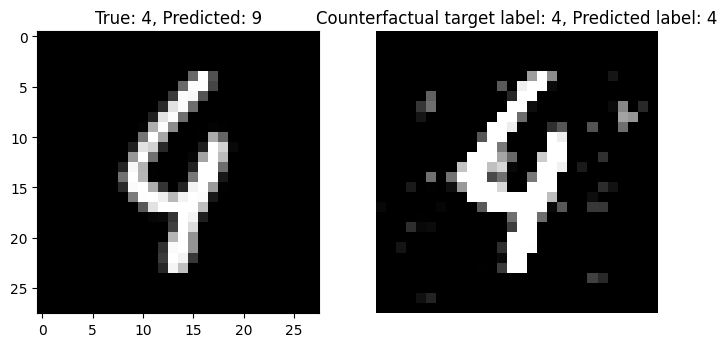

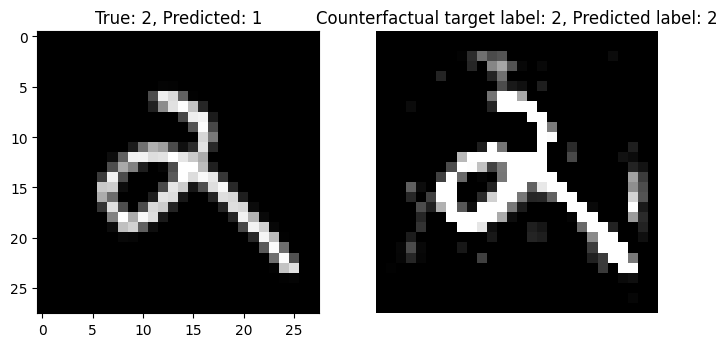

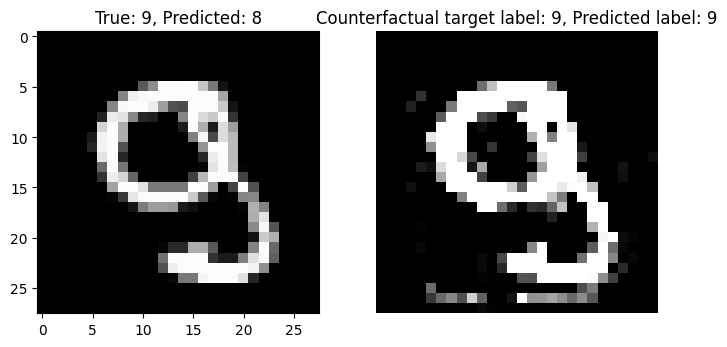

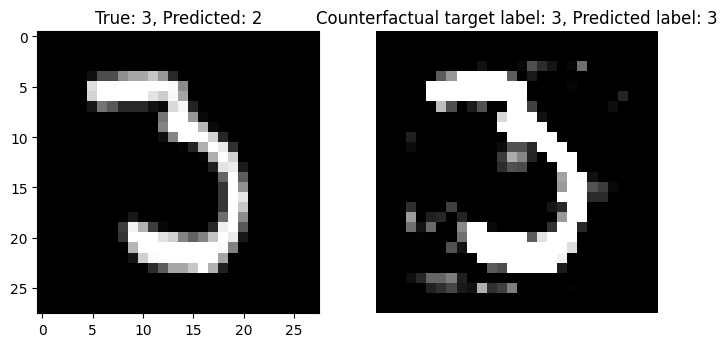

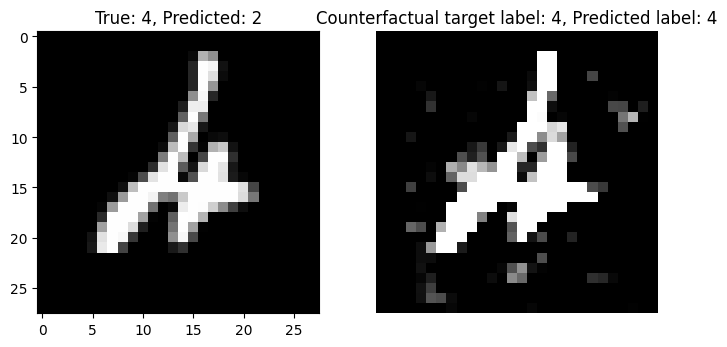

In [ ]:
def compute_l2_distance(x, x_cf):
    return torch.norm(x - x_cf, p=2)

def wachter_method(model, x, y_target, X_obs):

    lamda = 0.01
    lr = 0.01
    max_iter = 5000
    tol = 1e-2
    device = x.device
    model.eval()
    mad = compute_mad(X_obs.to(device))

    x_cf = x.clone().detach().requires_grad_(True).to(device)
    x_cf = torch.nn.Parameter(x_cf, requires_grad=True)
    optimizer = torch.optim.Adam([x_cf], lr=lr, weight_decay=1e-4)

    y_target_tensor = torch.tensor([y_target], dtype=torch.long, device=device)

    for i in range(max_iter):
        optimizer.zero_grad()
        output = model(x_cf.unsqueeze(0))
        probs = F.softmax(output, dim=1)
        target_prob = probs[0, y_target]

        loss_class = -torch.log(target_prob + 1e-8)

        loss_distance = compute_l2_distance(x, x_cf) + 1e-4 * torch.norm(x_cf, p=2)

        loss = loss_class + lamda * loss_distance
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            x_cf.data = torch.clamp(x_cf, 0.0, 1.0)

        pred_label = torch.argmax(output, dim=1).item()
        # if pred_label == y_target and loss_class.item() < tol:
        #     if i % 100 == 0:
        #         cf_image = x_cf.detach().cpu().squeeze()
        #         plt.imshow(cf_image.numpy(), cmap='gray')
        #         plt.title(f'Counterfactual target label: {y_target}, Predicted label: {pred_label}, iteration {i}')
        #         plt.axis('off')
        #         plt.show()

    return x_cf.detach(), pred_label

for iteration in range(5):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    x, true_label, predicted_label = misclassified_samples[iteration]
    axes[0].imshow(x.squeeze(), cmap='gray')
    axes[0].set_title(f'True: {true_label}, Predicted: {predicted_label}')

    x_tensor = torch.tensor(x).float().to(device)

    y_target = true_label

    X_obs = torch.stack([torch.tensor(img).float() for img, _, _ in correct_samples])

    cf_image, pred_label = wachter_method(model, x_tensor, y_target, X_obs)
    cf_image = cf_image.cpu().squeeze()
    axes[1].imshow(cf_image.numpy(), cmap='gray')
    axes[1].set_title(f'Counterfactual target label: {y_target}, Predicted label: {pred_label}')
    plt.axis('off')
    plt.show()



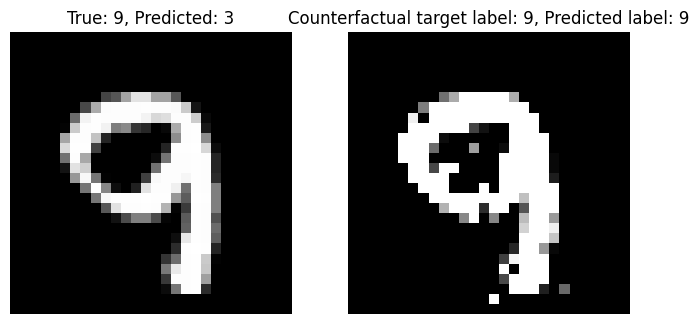

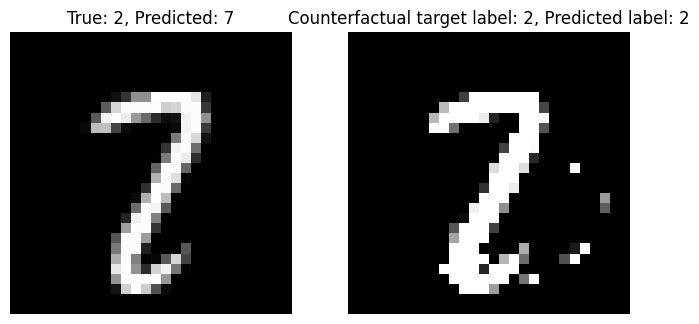

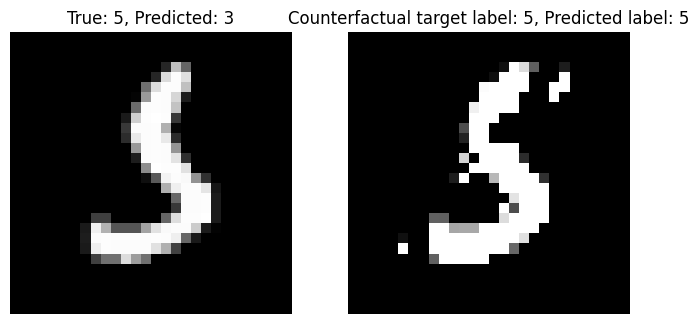

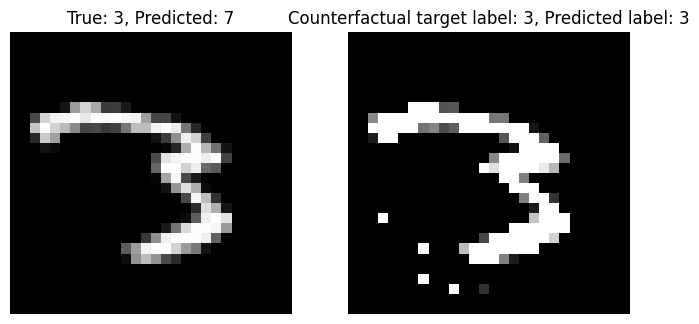

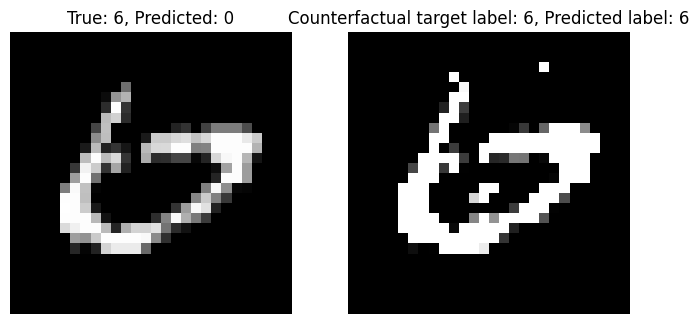

In [ ]:
def manhattan_distance(x, x_cf):
    return torch.norm(x - x_cf, p=1)

def wachter_method_manhattan(model, x, y_target, X_obs):

    lamda = 0.01
    lr = 0.01
    max_iter = 5000
    tol = 1e-2

    device = x.device
    model.eval()
    mad = compute_mad(X_obs.to(device))

    x_cf = x.clone().detach().requires_grad_(True).to(device)
    x_cf = torch.nn.Parameter(x_cf, requires_grad=True)
    optimizer = torch.optim.Adam([x_cf], lr=lr, weight_decay=1e-4)

    y_target_tensor = torch.tensor([y_target], dtype=torch.long, device=device)

    for i in range(max_iter):
        optimizer.zero_grad()

        output = model(x_cf.unsqueeze(0))
        probs = F.softmax(output, dim=1)
        target_prob = probs[0, y_target]

        loss_class = -torch.log(target_prob + 1e-8)
        loss_distance = manhattan_distance(x, x_cf) + 1e-4 * torch.norm(x_cf, p=1)

        loss = loss_class + lamda * loss_distance
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            x_cf.data = torch.clamp(x_cf, 0.0, 1.0)

        pred_label = torch.argmax(output, dim=1).item()
        # if pred_label == y_target and loss_class.item() < tol:
        #     if i % 100 == 0:
        #         cf_image = x_cf.detach().cpu().squeeze()
        #         plt.imshow(cf_image.numpy(), cmap='gray')
        #         plt.title(f'Counterfactual target label: {y_target}, Predicted label: {pred_label}, iteration {i}')
        #         plt.axis('off')
        #         plt.show()

    return x_cf.detach(), pred_label


for iteration in range(5):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    x, true_label, predicted_label = misclassified_samples[iteration + 5]
    axes[0].imshow(x.squeeze(), cmap='gray')
    axes[0].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[0].axis('off')
    x_tensor = torch.tensor(x).float().to(device)

    y_target = true_label

    X_obs = torch.stack([torch.tensor(img).float() for img, _, _ in correct_samples])

    cf_image, pred_label = wachter_method_manhattan(model, x_tensor, y_target, X_obs)
    cf_image = cf_image.cpu().squeeze()
    axes[1].imshow(cf_image.numpy(), cmap='gray')
    axes[1].set_title(f'Counterfactual target label: {y_target}, Predicted label: {pred_label}')
    axes[1].axis('off')
    plt.show()


# Dandl Method

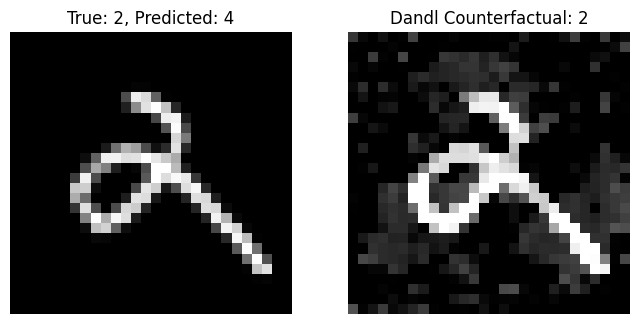

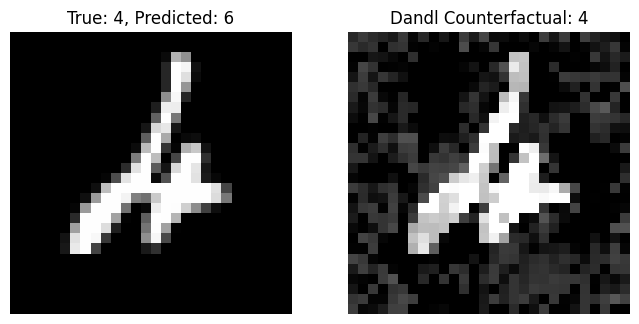

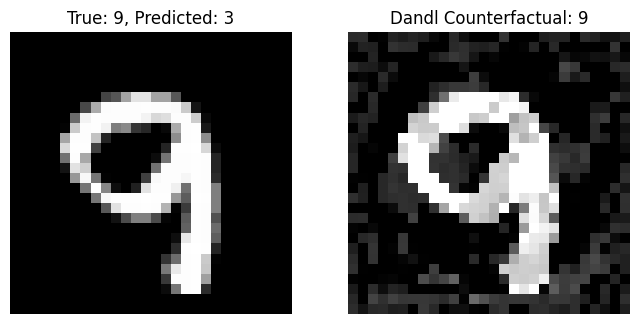

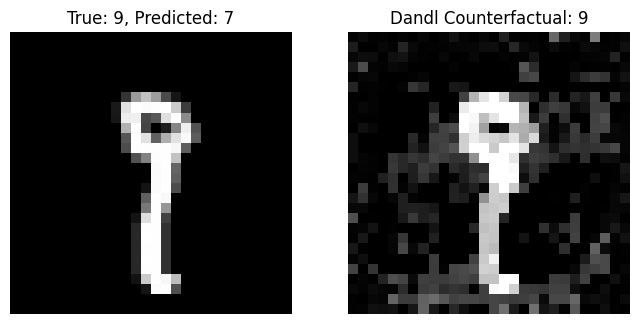

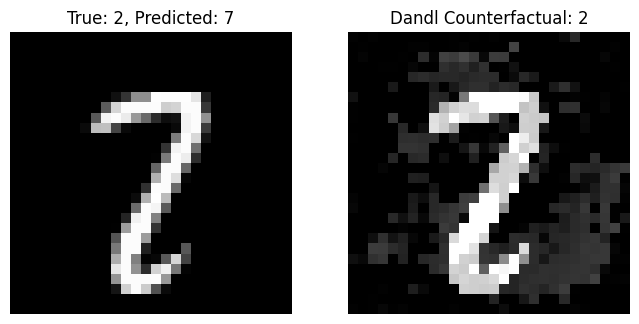

In [32]:
def gower_distance(y_cf, y_obs):
    y_obs = y_obs.clone().detach()
    y_cf = y_cf.clone().detach()
    p = y_obs.shape[-1]
    dists = torch.mean(torch.abs(y_obs - y_cf) / (torch.max(y_obs, dim=0).values - torch.min(y_obs, dim=0).values + 1e-8), dim=-1)
    return dists.mean()

def generate_dandl_counterfactual(model, image, target_label, X_obs, device, lr=0.01, steps=100):
    image_cf = image.clone().detach().requires_grad_(True)
    image_cf = torch.nn.Parameter(image_cf, requires_grad=True)
    optimizer = torch.optim.Adam([image_cf], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()

        outputs = model(image_cf.unsqueeze(0))
        preds = F.softmax(outputs, dim=1)
        target_prob = preds[:, target_label.squeeze()]

        o1 = -torch.log(target_prob + 1e-8).unsqueeze(1)
        o2 = gower_distance(image_cf.view(1, -1), image.view(1, -1)).unsqueeze(0)
        o3 = torch.sum(torch.abs(image_cf - image) > 0.1, dtype=torch.float32).unsqueeze(0)
        o4 = torch.mean(torch.tensor([gower_distance(image_cf.view(1, -1), x.view(1, -1)) for x in X_obs], dtype=torch.float32)).unsqueeze(0)

        loss = o1 + o2 + o3 + o4
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            image_cf.data = torch.clamp(image_cf, 0.0, 1.0)

    return image_cf.detach()

for iteration in range(5):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    image, true_label, predicted_label = misclassified_samples[iteration]
    y_target = true_label
    image_tensor = torch.tensor(image).float().to(device)
    target_label = torch.tensor([true_label]).to(device)
    X_obs = torch.stack([torch.tensor(img).float().clone().detach() for img, _, _ in correct_samples]).to(device)

    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[0].axis('off')

    dandl_cf_image = generate_dandl_counterfactual(model, image_tensor, target_label, X_obs, device)
    axes[1].imshow(dandl_cf_image.cpu().numpy().squeeze(), cmap='gray')
    axes[1].set_title(f'Dandl Counterfactual: {y_target}')
    axes[1].axis('off')
    plt.show()


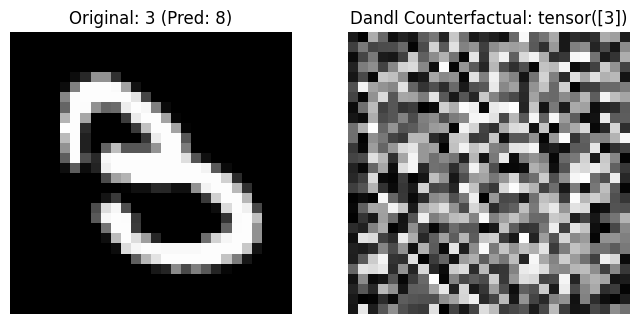

In [ ]:
def gower_distance(y_cf, y_obs):
    y_obs = y_obs.clone().detach().to(device)
    y_cf = y_cf.clone().detach().to(device)
    p = y_obs.shape[-1]
    dists = torch.mean(torch.abs(y_obs - y_cf) / (torch.max(y_obs, dim=0).values - torch.min(y_obs, dim=0).values + 1e-8), dim=-1)
    return dists.mean().unsqueeze(0)


def evaluate_objectives(model, images, target_label, original_image, X_obs):
    outputs = model(images)
    preds = F.softmax(outputs, dim=1)

    o1 = F.cross_entropy(outputs, target_label.repeat(images.shape[0]), reduction='none').unsqueeze(1)
    o2 = torch.norm(images - original_image, p=1, dim=[1, 2, 3]).unsqueeze(1)
    o3 = torch.sum(torch.abs(images - original_image) > 0.01, dim=[1, 2, 3]).unsqueeze(1)
    o4 = torch.tensor([gower_distance(img, X_obs) for img in images]).unsqueeze(1).to(device)

    return torch.cat([o1, o2, o3, o4], dim=1).detach().cpu().numpy()


def nsga2(model, original_image, target_label, X_obs, device, pop_size=100, generations=100, mutation_rate=0.1, crossover_rate=0.9):
    n_var = np.prod(original_image.shape)
    population = np.random.rand(pop_size, n_var)

    for generation in range(generations):
        offspring = []
        for _ in range(pop_size // 2):
            p1, p2 = np.random.choice(range(pop_size), size=2, replace=False)
            if np.random.rand() < crossover_rate:
                cross_point = np.random.randint(1, n_var - 1)
                child1 = np.concatenate((population[p1][:cross_point], population[p2][cross_point:]))
                child2 = np.concatenate((population[p2][:cross_point], population[p1][cross_point:]))
            else:
                child1, child2 = population[p1], population[p2]

            if np.random.rand() < mutation_rate:
                mutation_idx = np.random.randint(n_var)
                child1[mutation_idx] = np.random.rand()
                child2[mutation_idx] = np.random.rand()

            offspring.append(child1)
            offspring.append(child2)

        offspring = np.array(offspring)
        combined_population = np.vstack((population, offspring))


        reshaped_population = torch.tensor(combined_population, dtype=torch.float32).reshape((-1, *original_image.shape)).to(device)
        objectives = evaluate_objectives(model, reshaped_population, target_label, original_image, X_obs)

        ranks = np.argsort(np.sum(objectives, axis=1))
        population = combined_population[ranks[:pop_size]]

    return torch.tensor(population[0], dtype=torch.float32).reshape(original_image.shape).to(device)


def generate_dandl_counterfactual(model, image, target_label, X_obs, device):
    return nsga2(model, image, target_label, X_obs, device)

for iteration in range(5):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    image, true_label, predicted_label = misclassified_samples[iteration]
    y_target = true_label
    image_tensor = torch.tensor(image).float().to(device)
    target_label = torch.tensor([true_label]).to(device)
    X_obs = torch.stack([torch.tensor(img).float().clone().detach() for img, _, _ in correct_samples]).to(device)

    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[0].axis('off')

    dandl_cf_image =  dandl_cf_image = generate_dandl_counterfactual(model, image_tensor, target_label, X_obs, device)
    axes[1].imshow(dandl_cf_image.cpu().numpy().squeeze(), cmap='gray')
    axes[1].set_title(f'Dandl Counterfactual: {y_target}')
    axes[1].axis('off')
    plt.show()


# image, true_label, predicted_label = misclassified_samples[0]
# image_tensor = torch.tensor(image).float().to(device)
# target_label = torch.tensor([true_label]).to(device)
# X_obs = torch.stack([torch.tensor(img).float().clone().detach() for img, _, _ in correct_samples]).to(device)  # Fix user warning

# dandl_cf_image = generate_dandl_counterfactual(model, image_tensor, target_label, X_obs, device)

# plt.figure(figsize=(8, 4))
# plt.subplot(1, 2, 1)
# plt.imshow(image.squeeze(), cmap='gray')
# plt.title(f'Original: {true_label} (Pred: {predicted_label})')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(dandl_cf_image.cpu().numpy().squeeze(), cmap='gray')
# plt.title(f'Dandl Counterfactual: {target_label}')
# plt.axis('off')
# plt.show()

#Baseline using library
Reference: https://docs.seldon.io/projects/alibi/en/stable/examples/cf_mnist.html

#Question 2


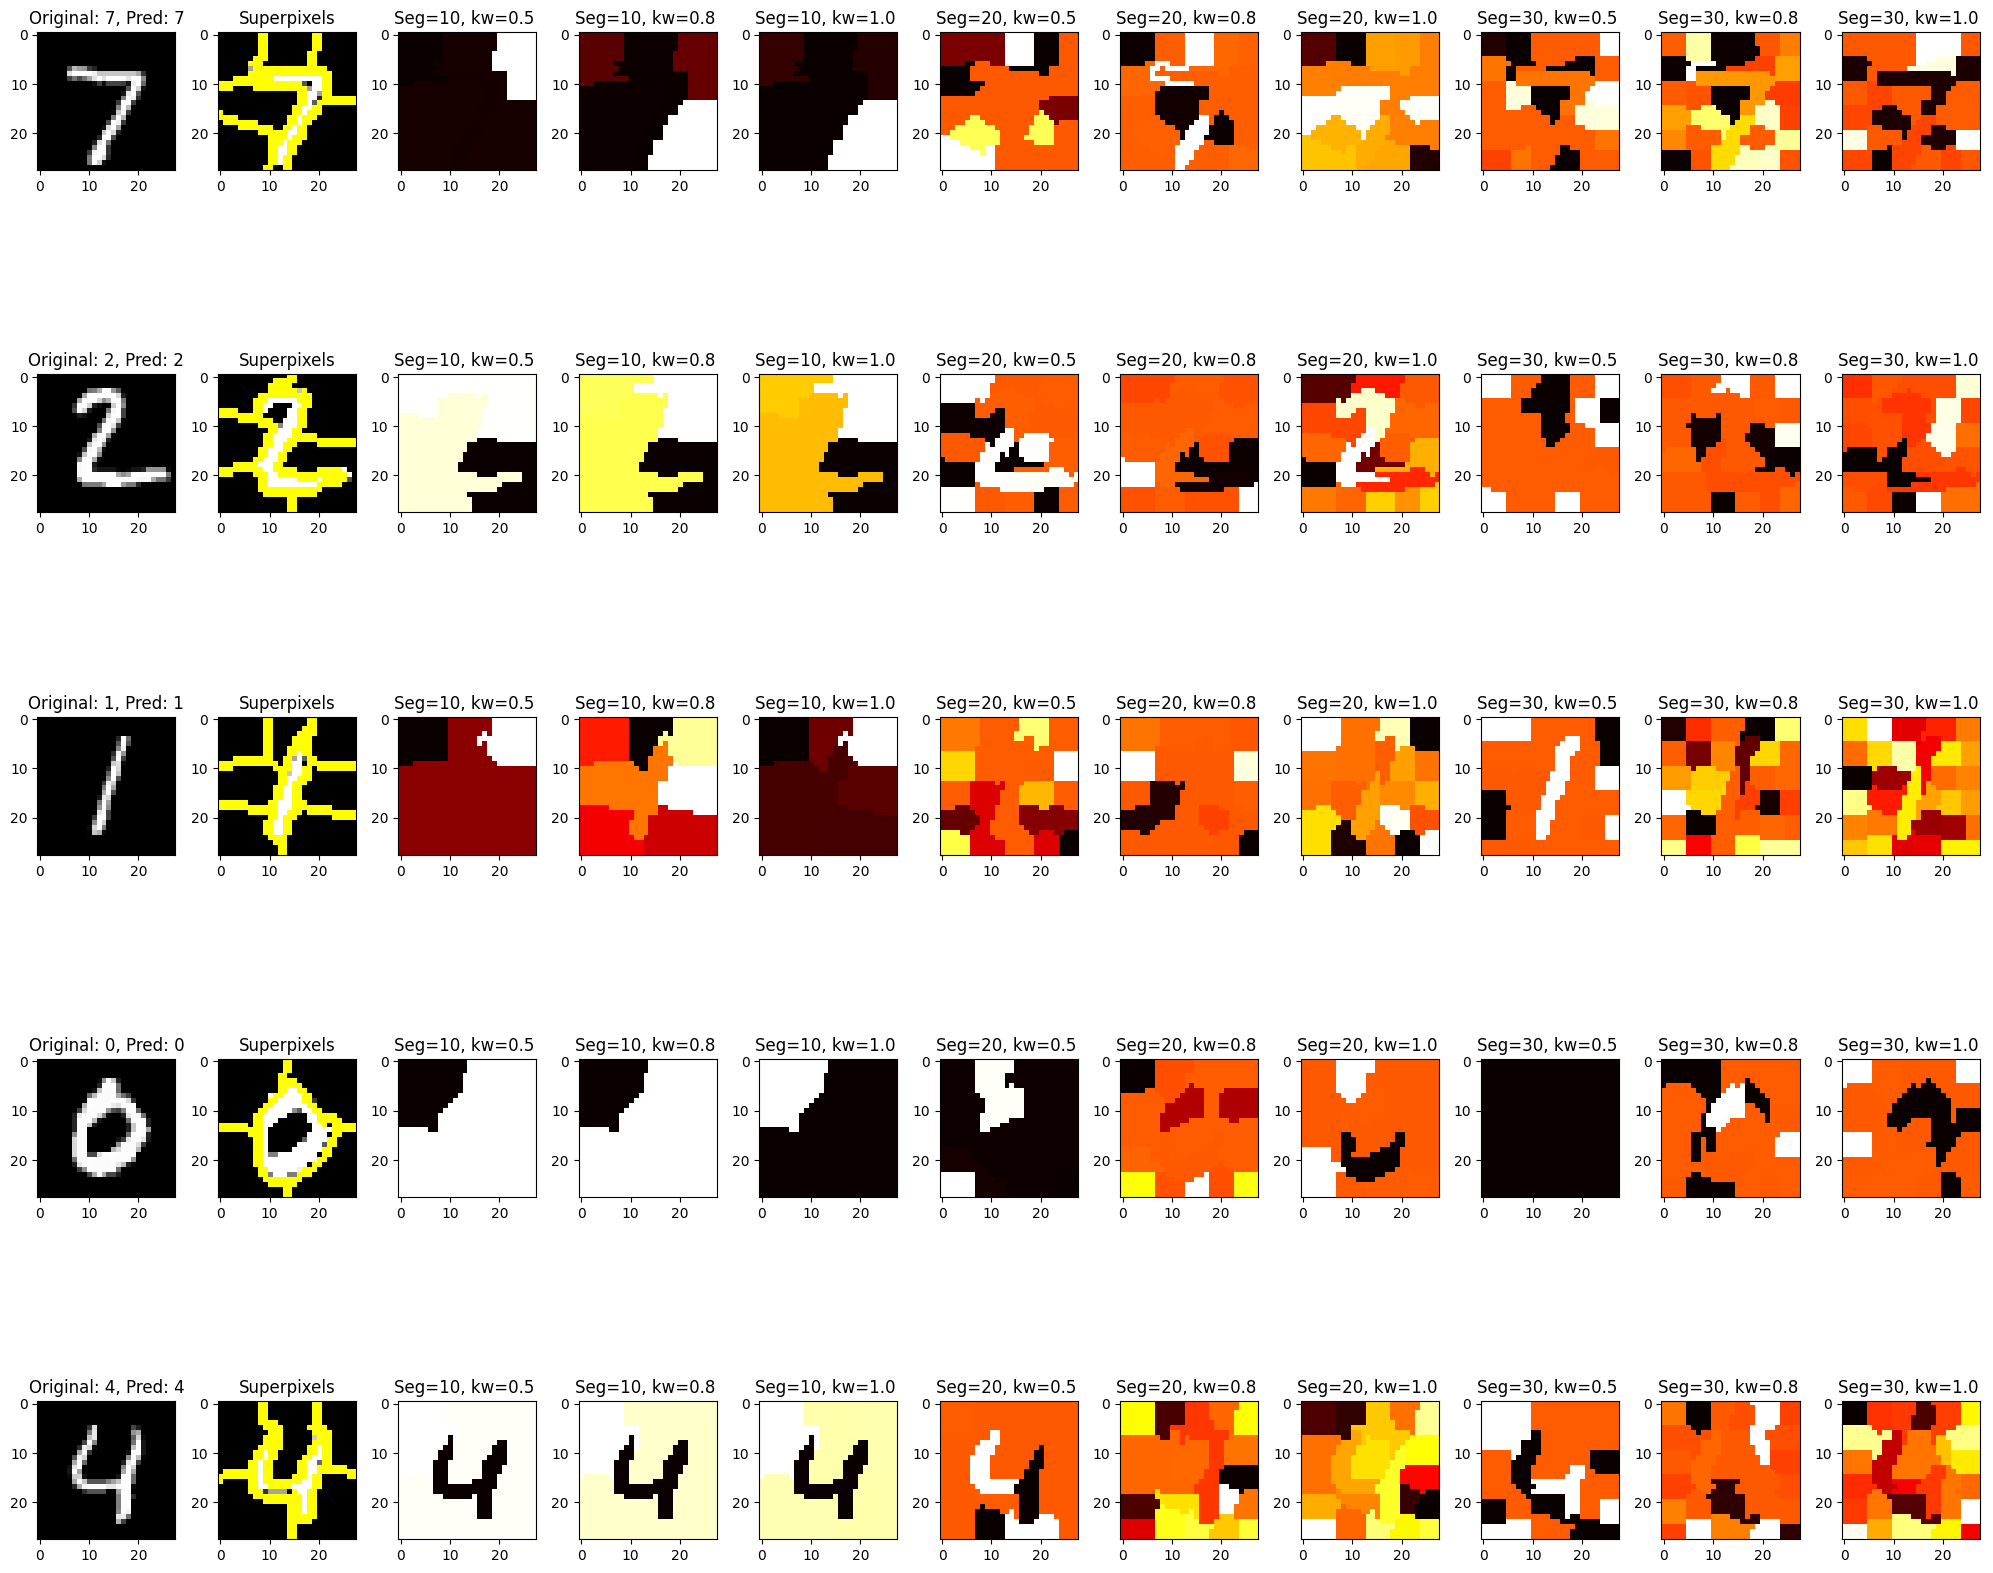

In [19]:
def lime(image, model, kernel_width, n_segments):
    num_samples = 1000
    image = image.squeeze()
    img_rgb = gray2rgb(img_as_float(image))
    segments = slic(img_rgb, n_segments = n_segments, compactness=10, sigma=1)

    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)

    perturbed_images = []
    perturbations = np.random.randint(0, 2, (num_samples, np.max(segments) + 1))

    for pert in perturbations:
        temp_image = image.copy()
        for seg in np.unique(segments):
            if pert[seg] == 0:
                temp_image[segments == seg] = 0
        perturbed_images.append(temp_image)

    perturbed_images = torch.tensor(np.array(perturbed_images), dtype=torch.float32).unsqueeze(1).to(device)

    with torch.no_grad():
        outputs = model(perturbed_images.view(num_samples, -1))
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    pred_labels = torch.argmax(outputs, dim=1).tolist()

    with torch.no_grad():
        original_prediction = torch.softmax(model(image_tensor.view(1, -1)), dim=1).cpu().numpy()

    predicted_label = np.argmax(original_prediction)

    distances = np.array([euclidean(image.flatten(), pert.flatten()) for pert in perturbed_images.cpu().numpy()])
    weights = np.exp(-distances ** 2 / (2 * kernel_width ** 2))

    regressor = Ridge(alpha=1.0)
    regressor.fit(perturbations, probs[:, predicted_label], sample_weight=weights)
    importance = regressor.coef_

    explanation_mask = np.zeros_like(image)
    for i, seg in enumerate(np.unique(segments)):
        explanation_mask[segments == seg] = importance[i]

    return perturbed_images, pred_labels, segments, explanation_mask


kernel_widths = [0.5, 0.8, 1.0]
segment_sizes = [10, 20, 30]

fig, axes = plt.subplots(5, len(kernel_widths) * len(segment_sizes) + 2, figsize=(20, 18))


for i, (image, true_label, pred_label) in enumerate(correct_samples[:5]):
    axes[i, 0].imshow(image.squeeze(), cmap='gray')
    axes[i, 0].set_title(f"Original: {true_label}, Pred: {pred_label}")

    segments = slic(gray2rgb(img_as_float(image.squeeze())), n_segments=10, compactness=10, sigma=1)
    axes[i, 1].imshow(mark_boundaries(image.squeeze(), segments))
    axes[i, 1].set_title("Superpixels")

    col = 2
    for n_segments in segment_sizes:
        for kernel_width in kernel_widths:
            perturbed_images, predicted_label, lime_segments, explanation_mask = lime(image, model, kernel_width, n_segments)
            # plt.imshow(perturbed_images[0].numpy().squeeze(), cmap = "gray")
            # plt.show()
            # print(predicted_label[0])

            axes[i, col].imshow(explanation_mask, cmap='hot')
            axes[i, col].set_title(f"Seg={n_segments}, kw={kernel_width} ")
            col += 1

plt.tight_layout()
plt.show()
